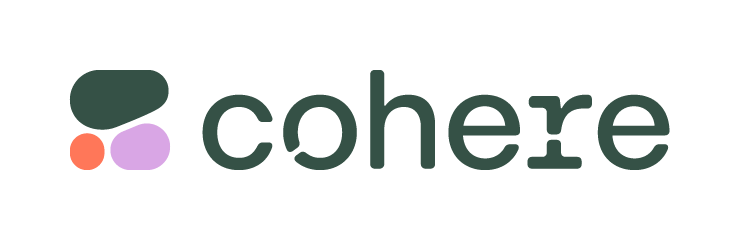

Capturing meeting notes is often a time consuming process, requiring a member to dedicate their attention to capturing notes and away from participating.

The following cookbook walks you through building your own meeting auto-notes tool for Google Meet + Google Calendar events, using the Cohere API, Google Calendar and Drive APIs and transcripts generated from Google Meet's "Transcribe" feature.

This cookbook will walk you through:


*   Downloading meeting transcript text from your Google Calendar Events that have a Google Meet link with transcripts enabled
*   Generating an auto-notes summary of the meeting transcript
*   Uploading the auto-notes to the Google Calendar Event and notifying participants

## Table of contents

1. [Create your project](###step-1-create-your-project)
2. [Set up your dependencies](###step-2-set-up-your-dependencies)
3. [Access your Google Calendar Events and download transcripts](###step-3-access-your-google-calendar-events-and-download-transcripts)
4. [Generate an auto-notes summary](###step-4-generate-an-auto-notes-summary)
5. [Upload summary to event and (optionally) share with participants](###step-5-upload-summary-to-event-and-optionally-share-with-participants)



### Step 1: Create your project

We're going to be using Google Calendar APIs to access your calendar events and download meeting transcript attachments. To do this, we first have to set up authentication for our app to access Google Calendar.



1.   Create a project in your [Google Cloud Console](https://console.cloud.google.com) or open an existing project.
2.   Search "Google Calendar API" in your search bar, and click "Enable" on the API page
3. Search "Google Drive API" and click "Enable" on the API page.
4. Under "Credentials" click "Create Credentials" -> "Oath Client ID"
5. Follow the Application creation flow, and select "Desktop app" as the Application Type. (We will cover how to modify this for remote deployment and chron job execution later).
  - Note: Make sure under scopes, select "Google Calendar API" and "Google Drive API"
6. Copy the CLIENT_ID and CLIENT_SECRET. You will need them in the next steps


### Step 2: Set up your dependencies

In [ ]:
%%capture
pip install --upgrade google-api-python-client google-auth-httplib2 google-cloud-storage cohere

### Step 3: Access your Google Calendar Events and download transcripts

First, let's set up authentication creds so you can access the Google Calendar API

In [ ]:
import json
import os
import googleapiclient.discovery
import google.oauth2.service_account
import pickle
from google_auth_oauthlib.flow import InstalledAppFlow
from google_auth_oauthlib.flow import Flow
from google.oauth2.credentials import Credentials
from google.auth.transport.requests import Request
from getpass import getpass
from typing import Any, Dict, List, Optional

# Scopes that offer read/write access to Google Calendar and Google Drive
SCOPES = ['https://www.googleapis.com/auth/calendar', 'https://www.googleapis.com/auth/drive']

#### REPLACE WITH FILEPATH TO YOUR CREDS ####
client_id = getpass("Client ID: ")
client_secret = getpass("Client Secret: ")

def get_credentials(write_to_cache=True, read_from_cache=True):
    creds = None

    # Attempt to load saved credentials
    if read_from_cache and os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            return pickle.load(token)
    else:
      if not creds or not creds.valid:
        # Refresh if creds are expired
        if creds and creds.expired and creds.refresh_token:
          creds.refresh(Request())
          return creds
        else:
          client_config = {
              "installed": {
                  "client_id": client_id,
                  "client_secret": client_secret,
                  "auth_uri": "https://accounts.google.com/o/oauth2/auth",
                  "token_uri": "https://oauth2.googleapis.com/token",
                  "redirect_uris": ["urn:ietf:wg:oauth:2.0:oob", "http://localhost"]
                  }
              }
          flow = InstalledAppFlow.from_client_config(client_config, SCOPES)

          # Redirect URI set to following to work for Google collab,
          # Can replace with a locally hosted server if running as a desktop script
          flow.redirect_uri = 'urn:ietf:wg:oauth:2.0:oob'
          auth_url, _ = flow.authorization_url(prompt='consent')
          print(f"Please go to this URL and authorize access: {auth_url}")
          code = input("Enter the authorization code: ")
          flow.fetch_token(code=code)
          creds = flow.credentials
          if write_to_cache:
            with open('token.pickle', 'wb') as token:
              pickle.dump(creds, token)
          return creds

Client ID: ··········
Client Secret: ··········


Now, let's use the creds in a method to read all the Google Calendar events from today.

In [ ]:
from googleapiclient.discovery import build
creds = get_credentials()
calender_service = build("calendar", "v3", credentials=creds)

def get_calendar_events(start_time, end_time):
  print(f"Getting events from {start_time} to: {end_time}")
  events_result = (
      calender_service.events()
      .list(
          calendarId="primary",
          timeMin=start_time,
          timeMax=end_time
      )
      .execute()
  )
  return events_result.get("items", [])


Please go to this URL and authorize access: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=634741174732-lom4tq4rugtbpbi0l5qpkdt52gqhhv9c.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcalendar+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=YmqLUArgd9TNZVMzJQsytOYYoSG6lJ&prompt=consent&access_type=offline
Enter the authorization code: 4/1AeaYSHC-7FbawGHYxWUlGyEgUBslBaITPSHo08mH9VzwaXQN9ReoMZc6GCQ


Let's test out our code by printing the names of all the meetings for the last 8 hours

In [ ]:
# Get meetings for last 8 hours
import datetime

lookback_hours = 8
start_time = (datetime.datetime.utcnow() - datetime.timedelta(hours=lookback_hours)).isoformat() + "Z"
end_time = datetime.datetime.utcnow().isoformat() + "Z"
events = get_calendar_events(start_time=start_time, end_time=end_time)
for event in events:
  print(event["summary"])

Getting events from 2024-03-16T06:17:13.874343Z to: 2024-03-16T14:17:13.874400Z
Flight to Zürich (UA 9747)
Flight to Zürich (UA 9729)
Test Meeting


Now, let's grab the attachments from the meeting, and extract all those which contain a "- Transcript" in their title. These reflect meeting transcripts captured using the Google Meet "Transcribe" feature.

**Note** If you don't have a meeting for which you've enabled "Transcribe" readily handy, you can make a copy of [this transcript from a Parliament meeting](https://docs.google.com/document/d/1vIVGWh2mIM220yc-hd0KP5VEFGa2eU8ILFBfFLsr4nI/edit#heading=h.pvm3n0pul0ky) and attach it to one of your Google Calendar Events you'll be testing with.

In [ ]:
# This substring is how we will filter for the Google Docs created automatically by Google Meet
# to capture meeting transcripts
TRANSCRIPT_ATTACHMENT_POSTSCRIPT = "- Transcript"

def get_attachments_for_event(event_id: str):
  event = calender_service.events().get(calendarId="primary",
                                              eventId=event_id).execute()
  if 'attachments' in event:
      return event["attachments"]
  else:
      return None

def get_attendees_for_event(event_id: str):
    event = calender_service.events().get(calendarId="primary", eventId=event_id).execute()
    if 'attendees' in event:
        return event["attendees"]
    else:
        return None

def get_meeting_transcript_attachment(attachments):
    if attachments is None or len(attachments) == 0:
        print("No attachments provided to get_meeting_transcript_from_attachments")
        return None

    annotation_attachments = [attachment for attachment in attachments if TRANSCRIPT_ATTACHMENT_POSTSCRIPT in attachment["title"]]
    if annotation_attachments is None or len(annotation_attachments) == 0:
        print("No annotation attachments found")
        return None
    annotation_attachment = annotation_attachments[0]
    return annotation_attachment


We can now download the text from the Transcript document, which we will use for the auto-notes summary. For this, we'll need to use the Google Drive API.

In [ ]:
import re
import io
from googleapiclient.http import MediaIoBaseDownload

drive_client = build('drive', 'v3', credentials=creds)

def download_from_attachment(attachment_id, download_path="downloads"):
  attachment_data = drive_client.files().get(fileId=attachment_id, supportsAllDrives=True).execute()

  file_mime_type = attachment_data['mimeType']
  if 'application/vnd.google-apps.document' not in file_mime_type:
      raise ValueError("Attachment is not a Google doc")

  # Filename to save transcript text
  local_filename = attachment_data['name']
  local_filename = re.sub(r'[^\w\s.-]', '', local_filename)
  local_filename = local_filename.replace(' ', '_')
  if not os.path.exists(download_path):
      os.makedirs(download_path)

  # Save transcript text file locally
  file_path = os.path.join(download_path, f"{local_filename}.txt")

  request = drive_client.files().export_media(fileId=attachment_id, mimeType='text/plain')
  fh = io.FileIO(file_path, 'wb')
  downloader = MediaIoBaseDownload(fh, request)

  done = False
  while not done:
      status, done = downloader.next_chunk()
      print(f"Downloaded {status.progress() * 100:.2f}% of {local_filename}.txt")

  # Return text from file
  with open(file_path, 'r') as f:
      text = f.read()
  return {
      "file_path": file_path,
      "content": text,
      "title": attachment_data['name']
  }

Let's put it all together to get the Google Meet transcripts for all Google Calendar events for the past 12 hours.

In [ ]:
import datetime
LOOKBACK_NUM_HOURS = 12

# Get meetings for last LOOKBACK_NUM_HOURS # of hours
start_time = (datetime.datetime.utcnow() - datetime.timedelta(hours=LOOKBACK_NUM_HOURS)).isoformat() + "Z"
end_time = datetime.datetime.utcnow().isoformat() + "Z"
events = get_calendar_events(start_time=start_time, end_time=end_time)

transcripts_for_events = {}
for event in events:
  attachments = get_attachments_for_event(event_id=event["id"])
  attendees= get_attendees_for_event(event_id=event["id"])
  event_name = event["summary"]
  meeting_transcript_attachment = get_meeting_transcript_attachment(attachments)
  if meeting_transcript_attachment is None or len(meeting_transcript_attachment) < 1:
    print(f"No transcripts found for event: {event_name}. Skipping")
    continue
  transcript = download_from_attachment(meeting_transcript_attachment["fileId"])
  transcripts_for_events[event["id"]] = {
      "transcript": transcript,
      "attendees": attendees
      }


Getting events from 2024-03-16T01:59:07.354257Z to: 2024-03-16T13:59:07.354353Z
No attachments provided to get_meeting_transcript_from_attachments
No transcripts found for event: Flight to Zürich (UA 9747). Skipping
No attachments provided to get_meeting_transcript_from_attachments
No transcripts found for event: Flight to Zürich (UA 9729). Skipping
Downloaded 100.00% of Example_meeting_transcript_-_Transcript.txt


### Step 4: Generate an auto-notes summary

---

Now that we have the Google transcript, we'll use Cohere's `co.chat` API to generate the summary. We could just ask for a generic summary of meeting. Instead, we can also request the model to attend to specific elements, e.g.:

1. What are the action items that follow from the meeting?
2. What were the perspectives or views expressed by each participant?

We'll implement the generic summary below, with the option to toggle modes 1. and 2. For more recipes for tailoring your meeting summaries, you can refer to [this cookbook](https://colab.research.google.com/drive/1XqRpJH7qRnRTbOEt6kthwqZG6gtEn4gN).


First, let's set up the Cohere client with a Cohere API key.

In [ ]:
import cohere

co_api_key = getpass("Cohere API Key: ")
co = cohere.Client(api_key=co_api_key)

Cohere API Key: ··········


In [ ]:
from enum import Enum

class MeetingOptions(Enum):
    ACTION_ITEMS = "action_items"
    PERSPECTIVES = "meeting_perspectives"


def generate_aut_notes_summary_for_text(meeting: str, options: Optional[List[MeetingOptions]] = []) -> str:
    """
    Uses co.chat to summarise the Google Meet transcript
    """

    preamble = """\
You're a highly-skilled AI that excels at producing exhaustive, complete summaries of meeting transcripts. \
Follow the instructions below to summarize the meeting transcript to the best of your abilities. \
Ensure that your responses are accurate and truthful, and that you follow the instructions to the letter, \
regardless of their complexity.
    """

    postamble = """\
Don't include preambles, postambles or explanations, but respond only with the requested summary or summaries.
    """

    instructions = build_instructions(options)
    instructions = instructions + "\n" + postamble
    prompt = f"""
    ## meeting transcript
    {meeting}

    ## instructions
    {instructions}

    ## answer
    """

    # Generate summary
    resp = co.chat(
        message=prompt,
        preamble=preamble,
        model="command-r",
        prompt_truncation="AUTO",
        temperature=0.3
    )
    return resp.text

def build_instructions(options: Optional[List[MeetingOptions]] = []) -> str:
    """
    Helper function that composes the instructions based on options provided by the user
    """

    instructions = "Produce a summary of the meeting transcript, including all key events, discussion items and decisions."
    formatting = "Format your answer in the form of bullets."

    valid_options = set([MeetingOptions.ACTION_ITEMS, MeetingOptions.PERSPECTIVES])
    requested_options = set(options).intersection(valid_options)
    if requested_options != options:
        print(f"Only executing known options: {requested_options}")

    if not requested_options:
        instructions = instructions + "\n" + formatting
    else:
        # Compose instructions, based on the options
        counter = 0

        if MeetingOptions.ACTION_ITEMS in requested_options:
            instructions_action_items = """\
In addition, produce a second summary of the meeting transcript focused exclusively around action items. \
Make sure to include the person each action item is assigned to."""
            instructions = instructions + "\n" + instructions_action_items
            counter += 1

        if MeetingOptions.PERSPECTIVES in requested_options:
            position = "second" if counter == 0 else "third"
            instructions_perspectives = f"""\
In addition, produce a {position} summary of the meeting transcript summarizing the perspective of every speaker."""
            instructions = instructions + "\n" + instructions_perspectives

        # Add formatting at the end
        instructions = instructions + "\n" + formatting

    return instructions

Let's try it out! We'll use the method above to generate an auto-notes summary for each event we pulled earlier. For this demo, we'll use both the ACTION_ITEMS and PERSPECTIVES options to get both action items and perspective summaries from the meeting transcripts.

In [ ]:
auto_notes_for_events = {}
for event_id in transcripts_for_events.keys():
  transcript = transcripts_for_events[event_id]["transcript"]
  transcript_text = transcript["content"]
  auto_notes_text = generate_aut_notes_summary_for_text(meeting=transcript_text, options=[MeetingOptions.ACTION_ITEMS, MeetingOptions.PERSPECTIVES])
  print("Successfully generated auto-notes for transcript for event id: ", event_id)
  auto_notes_for_events[event_id] = auto_notes_text

Only executing known options: {<MeetingOptions.PERSPECTIVES: 'meeting_perspectives'>, <MeetingOptions.ACTION_ITEMS: 'action_items'>}
Successfully generated auto-notes for transcript for event id:  78mto429um7njc1io1msjcamdn


### Step 5: Upload summary to event and (optionally) share with participants

Finally, we will create a Google Doc from the generated auto-notes, attach the notes to the original Google Calendar event, and notify all participants (optional).

The following methods will help create the Google Doc from text and share them with the meeting participants.

In [ ]:
from googleapiclient.http import MediaFileUpload

def share_google_doc(doc_id: str,
                     share_with: Dict[str, Any],
                     permission: str,
                     send_notification_emails: bool):
  permission = {
      'role': permission,
      'type': 'user',
      'emailAddress': share_with["email"],
  }
  drive_client.permissions().create(fileId=doc_id, body=permission, sendNotificationEmail=send_notification_emails).execute()

def write_to_file(filename, content):
    with open(filename, 'w') as file:
        file.write(content)
    print(f"Content written to {filename}")

def generate_google_doc_from_notes_summary_text(text, title: str, share_with: List[Dict[str, Any]], send_notification_emails: bool):
  tmp_filename = "tmp_autonotes.txt"
  write_to_file(tmp_filename, text)
  media = MediaFileUpload(tmp_filename, mimetype='text/plain')
  file_metadata = {
      'name': title,
      'mimeType': 'application/vnd.google-apps.document',
  }
  doc = drive_client.files().create(body=file_metadata,
                                          media_body=media,
                                          supportsAllDrives=True).execute()
  for user in share_with:
      try:
          share_google_doc(doc['id'], user, 'writer', send_notification_emails=send_notification_emails)
      except Exception as e:
          print(f"Failed to share google doc with user: {user} with error: {e}")
  return doc


Now that we've got our auto notes text, let's create a Google Doc with the text, share it with the meeting participants. We'll title this doc with the meeting name + " - Auto Notes". We'll also use the send_notification_emails parameter to notify the event attendees.

In [ ]:
notes_gdocs_for_events = {}

# Generate auto-notes google doc for all events
for event in events:
  if event["id"] not in auto_notes_for_events.keys():
    print("Event does not have auto notes. Skipping")
    continue
  auto_notes_text = auto_notes_for_events[event["id"]]
  doc_title = event["summary"] + " - Auto Notes"
  if "attendees" not in event:
    print("Skipping, no attendees for event: ", event["summary"])
    continue
  attendees = event["attendees"]
  auto_notes_google_doc = generate_google_doc_from_notes_summary_text(text=auto_notes_text,
                                                                      title=doc_title,
                                                                      share_with=attendees,
                                                                      send_notification_emails=True)
  notes_gdocs_for_events[event["id"]] = auto_notes_google_doc

Event does not have auto notes. Skipping
Event does not have auto notes. Skipping
Content written to tmp_autonotes.txt


Great! Now, you should see a Google Doc with the auto-notes in your Google Drive. Now let's finish things up by uploading the Google Doc as an attachment to the original Google Calendar event

In [ ]:
def get_doc_info(id: str):
        return drive_client.files().get(fileId=id,
                                              fields='webViewLink, name, mimeType').execute()

def upload_doc_to_event(doc: Dict[str, Any], event_id: str):
  event = calender_service.events().get(calendarId="primary",
                                       eventId=event_id).execute()
  attachment = {
      'fileUrl': doc["webViewLink"],
      'mimeType': doc['mimeType'],
      'title': doc['name']
  }

  if 'attachments' not in event:
      event['attachments'] = []
  event['attachments'].append(attachment)
  changes = {
      'attachments': event['attachments']
  }
  calender_service.events().patch(calendarId="primary",
                                        eventId=event_id,
                                        body=changes,
                                        supportsAttachments=True).execute()

# Upload notes for all events
for event_id, gdoc in notes_gdocs_for_events.items():
  gdoc_info = get_doc_info(id=gdoc["id"])
  upload_doc_to_event(gdoc_info, event_id)

## Conclusion

In this cookbook, we've shown how you can use Cohere API's, Google Calendar and Drive APIs and the "Transcribe" feature of Google Meet to automatically generate summaries and notes for your meetings. We've also shown you how you can customize what you want to see in your notes with options such as action items and perspectives.

To scale your work and automatically run this for all your meetings and the meetings of others in your organization, you can deploy this work as a [Google Cloud Function](https://cloud.google.com/functions?hl=en) using [a Google service account](https://cloud.google.com/iam/docs/service-account-overview) with [domain-wide delegation](https://support.google.com/a/answer/162106?hl=en). You can also schedule this to run automatically for all your meetings at scheduled intervals using [Google Cloud Scheduler](https://cloud.google.com/scheduler) to trigger your Cloud Function.

Follow the linked documentation to learn how, or contact us to help you get the most out of your meeting summaries!